# Segmentation map으로 도로 이미지 만들기

In [1]:
import os
import cv2
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation


import matplotlib.pyplot as plt

## Step 1. 데이터 준비하기

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


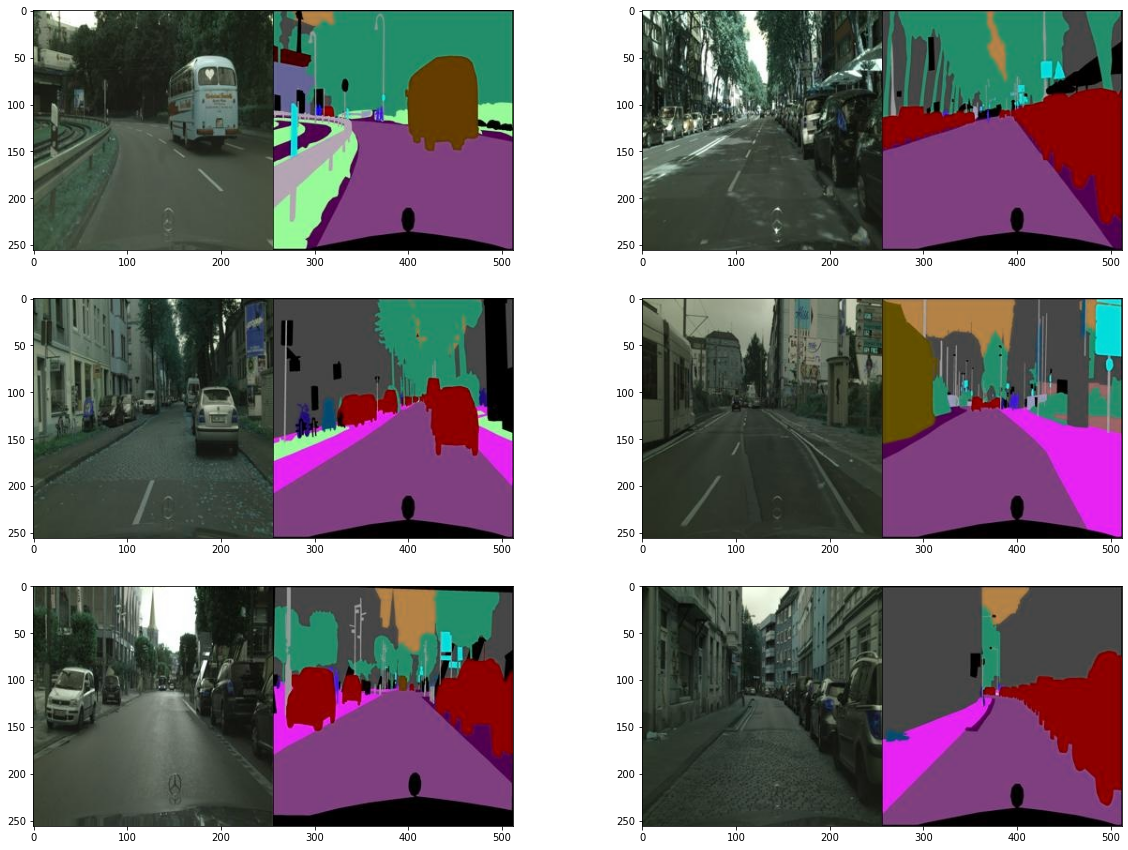

In [3]:
# 데이터 확인
plt.figure(figsize=(20,15))

for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
# 이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


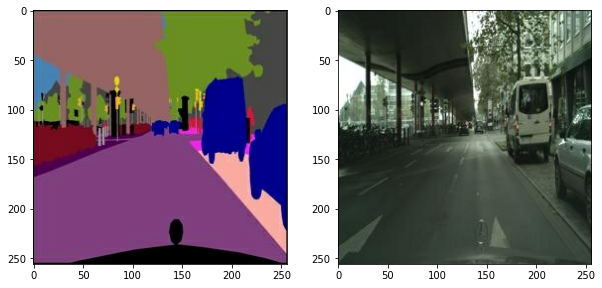

In [5]:
# 도로이미지 분리
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    segmented = img[:, w:, :] 
    segmented = tf.cast(segmented, tf.float32)
    return normalize(segmented), normalize(colored)

f = data_path + os.listdir(data_path)[1]
segmented, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segmented))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## Step 2. Data Augmentation

In [6]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용
def apply_augmentation(seg, colored):
    stacked = tf.concat([seg, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5: #50% 확률로 reflection, constant padding 적용
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out) 
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

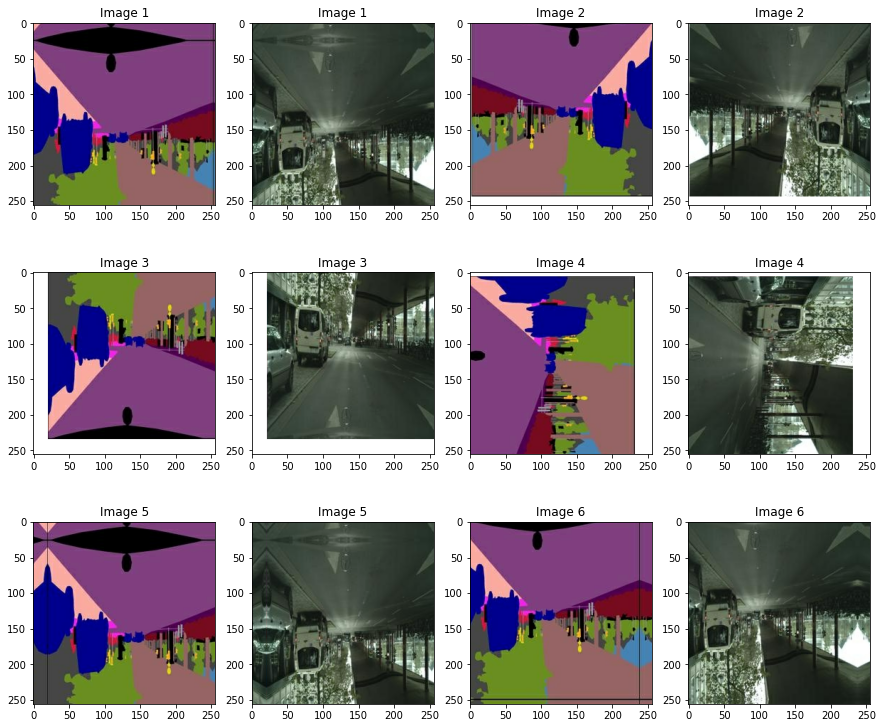

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg, augmented_colored = apply_augmentation(segmented, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

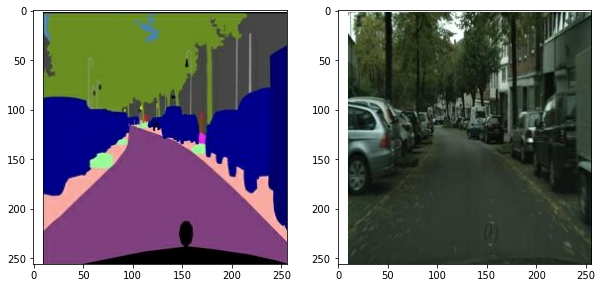

In [8]:
# 전체 적용
def get_train(img_path):
    seg, colored = load_img(img_path)
    seg, colored = apply_augmentation(seg, colored)
    return seg, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
seg, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## Step 3. U-net based model 구성하기

In [9]:
# Generator
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
# 기존 구조에 Skip connection 추가
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] #encoder의 마지막 출력은 skip connection 적용할 필요 없으므로
                    
        for block, feat in zip(self.decode_blocks, features[::-1]): #skip-connection은 뒤 feature 부터 진행되므로
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [11]:
# 구조 확인
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

In [12]:
# Discriminator
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

In [13]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [15]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

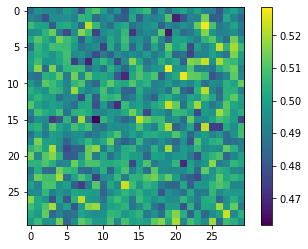

In [16]:
# 랜덤 시각화
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## Step 4. 학습하기

In [17]:
# 손실 함수(L1+GAN)
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [18]:
# Optimizer
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [19]:
# Train_step
@tf.function
def train_step(seg, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(seg, training=True)
        # Discriminator 예측
        fake_disc = discriminator(seg, fake_colored, training=True)
        real_disc = discriminator(seg, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [20]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (segmented, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmented, colored)
                
        # 100회 반복마다 손실을 출력
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:1.1080                     
L1_loss:0.2045                     
Discriminator_loss:0.9587

EPOCH[1] - STEP[200]                     
Generator_loss:1.6832                     
L1_loss:0.1988                     
Discriminator_loss:0.5098

EPOCH[2] - STEP[100]                     
Generator_loss:0.3467                     
L1_loss:0.2123                     
Discriminator_loss:1.5658

EPOCH[2] - STEP[200]                     
Generator_loss:0.8580                     
L1_loss:0.2021                     
Discriminator_loss:0.8930

EPOCH[3] - STEP[100]                     
Generator_loss:2.1250                     
L1_loss:0.1885                     
Discriminator_loss:0.4652

EPOCH[3] - STEP[200]                     
Generator_loss:1.2048                     
L1_loss:0.1956                     
Discriminator_loss:0.6918

EPOCH[4] - STEP[100]                     
Generator_loss:0.8884                     
L1_loss:0.1958             

EPOCH[29] - STEP[100]                     
Generator_loss:1.1338                     
L1_loss:0.1740                     
Discriminator_loss:0.9411

EPOCH[29] - STEP[200]                     
Generator_loss:1.9639                     
L1_loss:0.2006                     
Discriminator_loss:0.2604

EPOCH[30] - STEP[100]                     
Generator_loss:2.3873                     
L1_loss:0.2072                     
Discriminator_loss:0.3681

EPOCH[30] - STEP[200]                     
Generator_loss:2.0412                     
L1_loss:0.1694                     
Discriminator_loss:0.9772

EPOCH[31] - STEP[100]                     
Generator_loss:2.4753                     
L1_loss:0.1598                     
Discriminator_loss:0.8707

EPOCH[31] - STEP[200]                     
Generator_loss:0.8685                     
L1_loss:0.2287                     
Discriminator_loss:0.8899

EPOCH[32] - STEP[100]                     
Generator_loss:1.1624                     
L1_loss:0.1329      

## Step 5. 훈련된 모델 이용해 도로 이미지 생성하기

In [21]:
valid_dir = os.getenv("HOME")+'/aiffel/conditional_generation/data/cityscapes/val/'

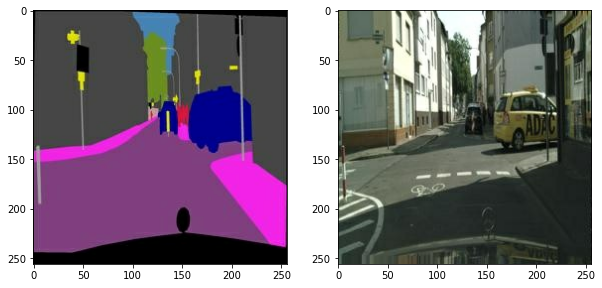

In [22]:
f = valid_dir + os.listdir(valid_dir)[0]
seg, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [23]:
valid_images = data.Dataset.list_files(valid_dir+ "*.jpg")
valid_images = valid_images.map(load_img)

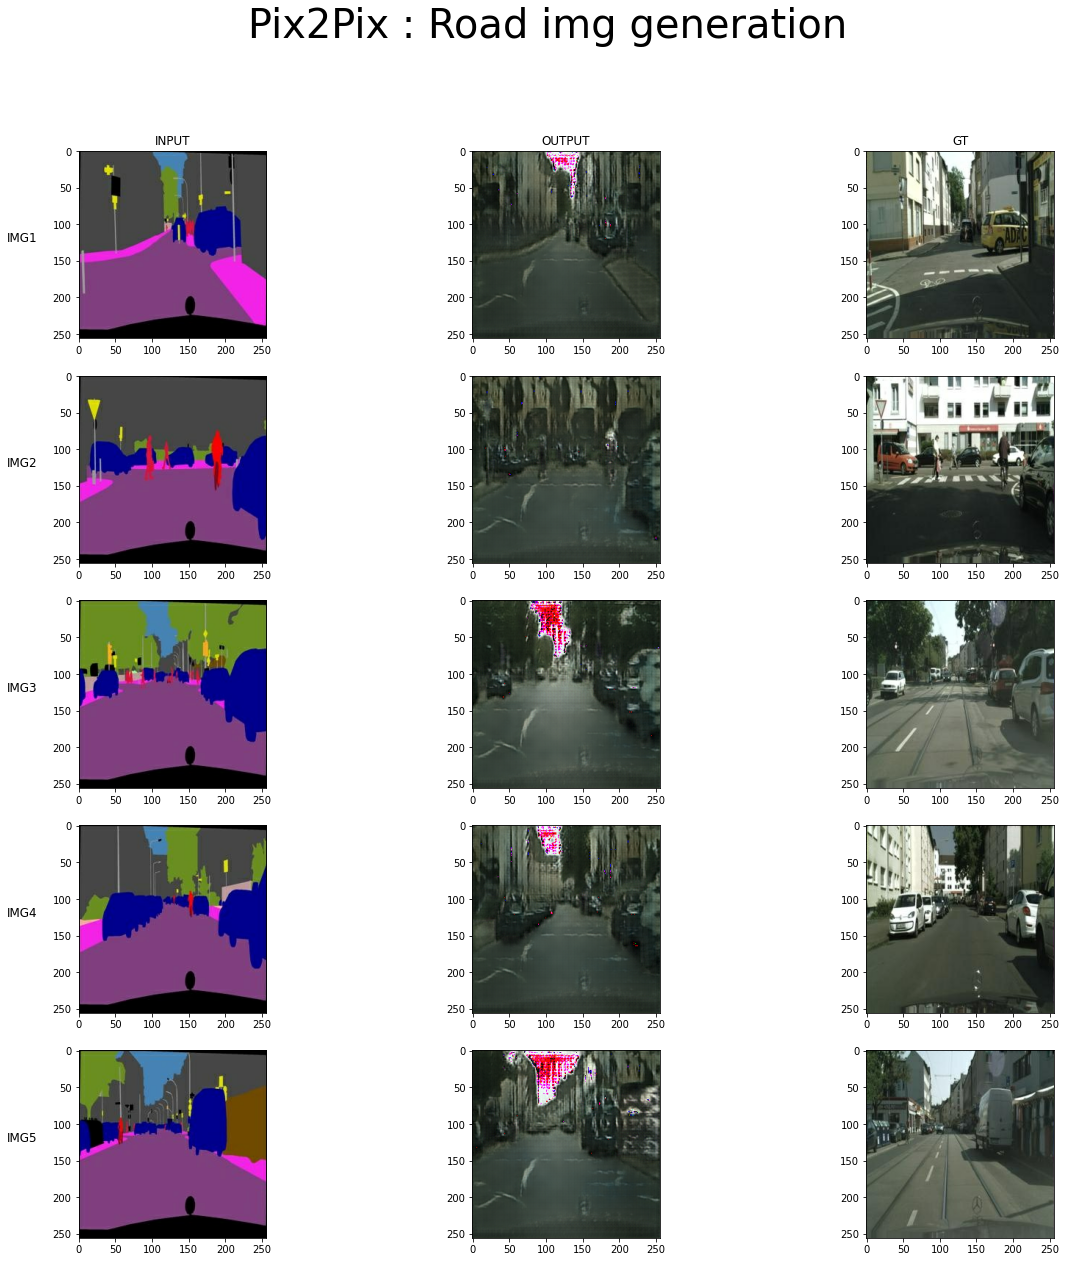

In [24]:
fig,axes = plt.subplots(5,3,figsize=(20,20))

cols = ['INPUT','OUTPUT','GT'] #col 이름
rows = ['IMG1','IMG2','IMG3','IMG4','IMG5'] #row 이름

for i,(seg,colored) in enumerate(valid_images): 
    
    pred = generator(tf.expand_dims(seg, 0))
    pred = denormalize(pred)
    row, col = i, 0
    
    axes[row][col].imshow(denormalize(seg))
    axes[row][col+1].imshow(pred[0])
    axes[row][col+2].imshow(denormalize(colored))
    

for ax, col in zip(axes[0], cols): #columns 공통 이름 설정
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows): #rows 공통 이름 설정
    ax.set_ylabel(row, labelpad=30,rotation=0, size='large')
    
plt.suptitle('Pix2Pix : Road img generation',fontsize=40) #공통 타이틀 설정
plt.show()

- 그래도 EPOCHS=50으로 설정했을 때 형체는 나오는 것을 확인했다. EPOCHS 수를 높이면 더 괜찮은 결과가 나왔을 거 같다. 